In [1]:
import os        # File and directory operations
import random    # Random number generation
import numpy as np  # Numerical computations
import pandas as pd # Data handling with DataFrames
import torch     # PyTorch for deep learning
import matplotlib.pyplot as plt  # Plotting graphs
from PIL import Image  # Working with images
from collections import defaultdict  # Handling dictionaries with default values
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Remove numerical suffix and match class format
import re

%matplotlib inline  


import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras  # High-level API for building models
from tensorflow.keras import backend as K

2025-05-16 04:27:37.300547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747369657.478389      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747369657.533562      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Analysis**

Data analysis revealed that data has 38 classes and a mild imbalance of among classes. A dataset with **38 classes** and **mild imbalance** presents several challenges in deep learning and model training. Here’s a breakdown of potential challenges:

### **1. High Computational Cost**  
- Training a deep learning model on a **large, multi-class dataset** requires significant computing power, especially for complex architectures like CNNs.  
- **Memory constraints** could arise if handling high-resolution images or large batch sizes.

### **2. Class Imbalance Effects**  
- **Minor imbalance** might still affect the model’s ability to generalize properly. Some classes with fewer samples might have lower accuracy.  
- The model may **favor classes with more images**, leading to **biased predictions** toward dominant categories.

### **3. Intra-class Variability**  
- Some plant diseases have **similar visual symptoms**, making classification tricky.  
- Subtle **variations in lighting, angle, or environmental conditions** might cause misclassification.

## **Exploring Directory Structure**

#### Here we set up directory paths for the plant disease dataset stored on Kaggle. It defines the root directory and subdirectories for training, validation, and testing data. The os.listdir(train_dir) command retrieves the list of disease classes present in the training dataset, helping analyze and structure the data for model training.


In [3]:
Root_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "/kaggle/input/new-plant-diseases-dataset/test/test"
Diseases_classes = os.listdir(train_dir)

## **Analyzing total number of classes in dataset**

#### Total number of directories will tell us the total number of classes in dataset

In [4]:
print(str(Diseases_classes))
print("\nTotal number of classes are: ", len(Diseases_classes))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

## **Class Distribution Analysis And Data Sample Visualization**

#### Here we first visualize the class distribution of the plant disease dataset using a histogram, showing the number of images in each disease category. Then, we display sample images from each class to provide an overview of the dataset. This helps in assessing dataset balance and understanding variations in plant disease images before training the model.

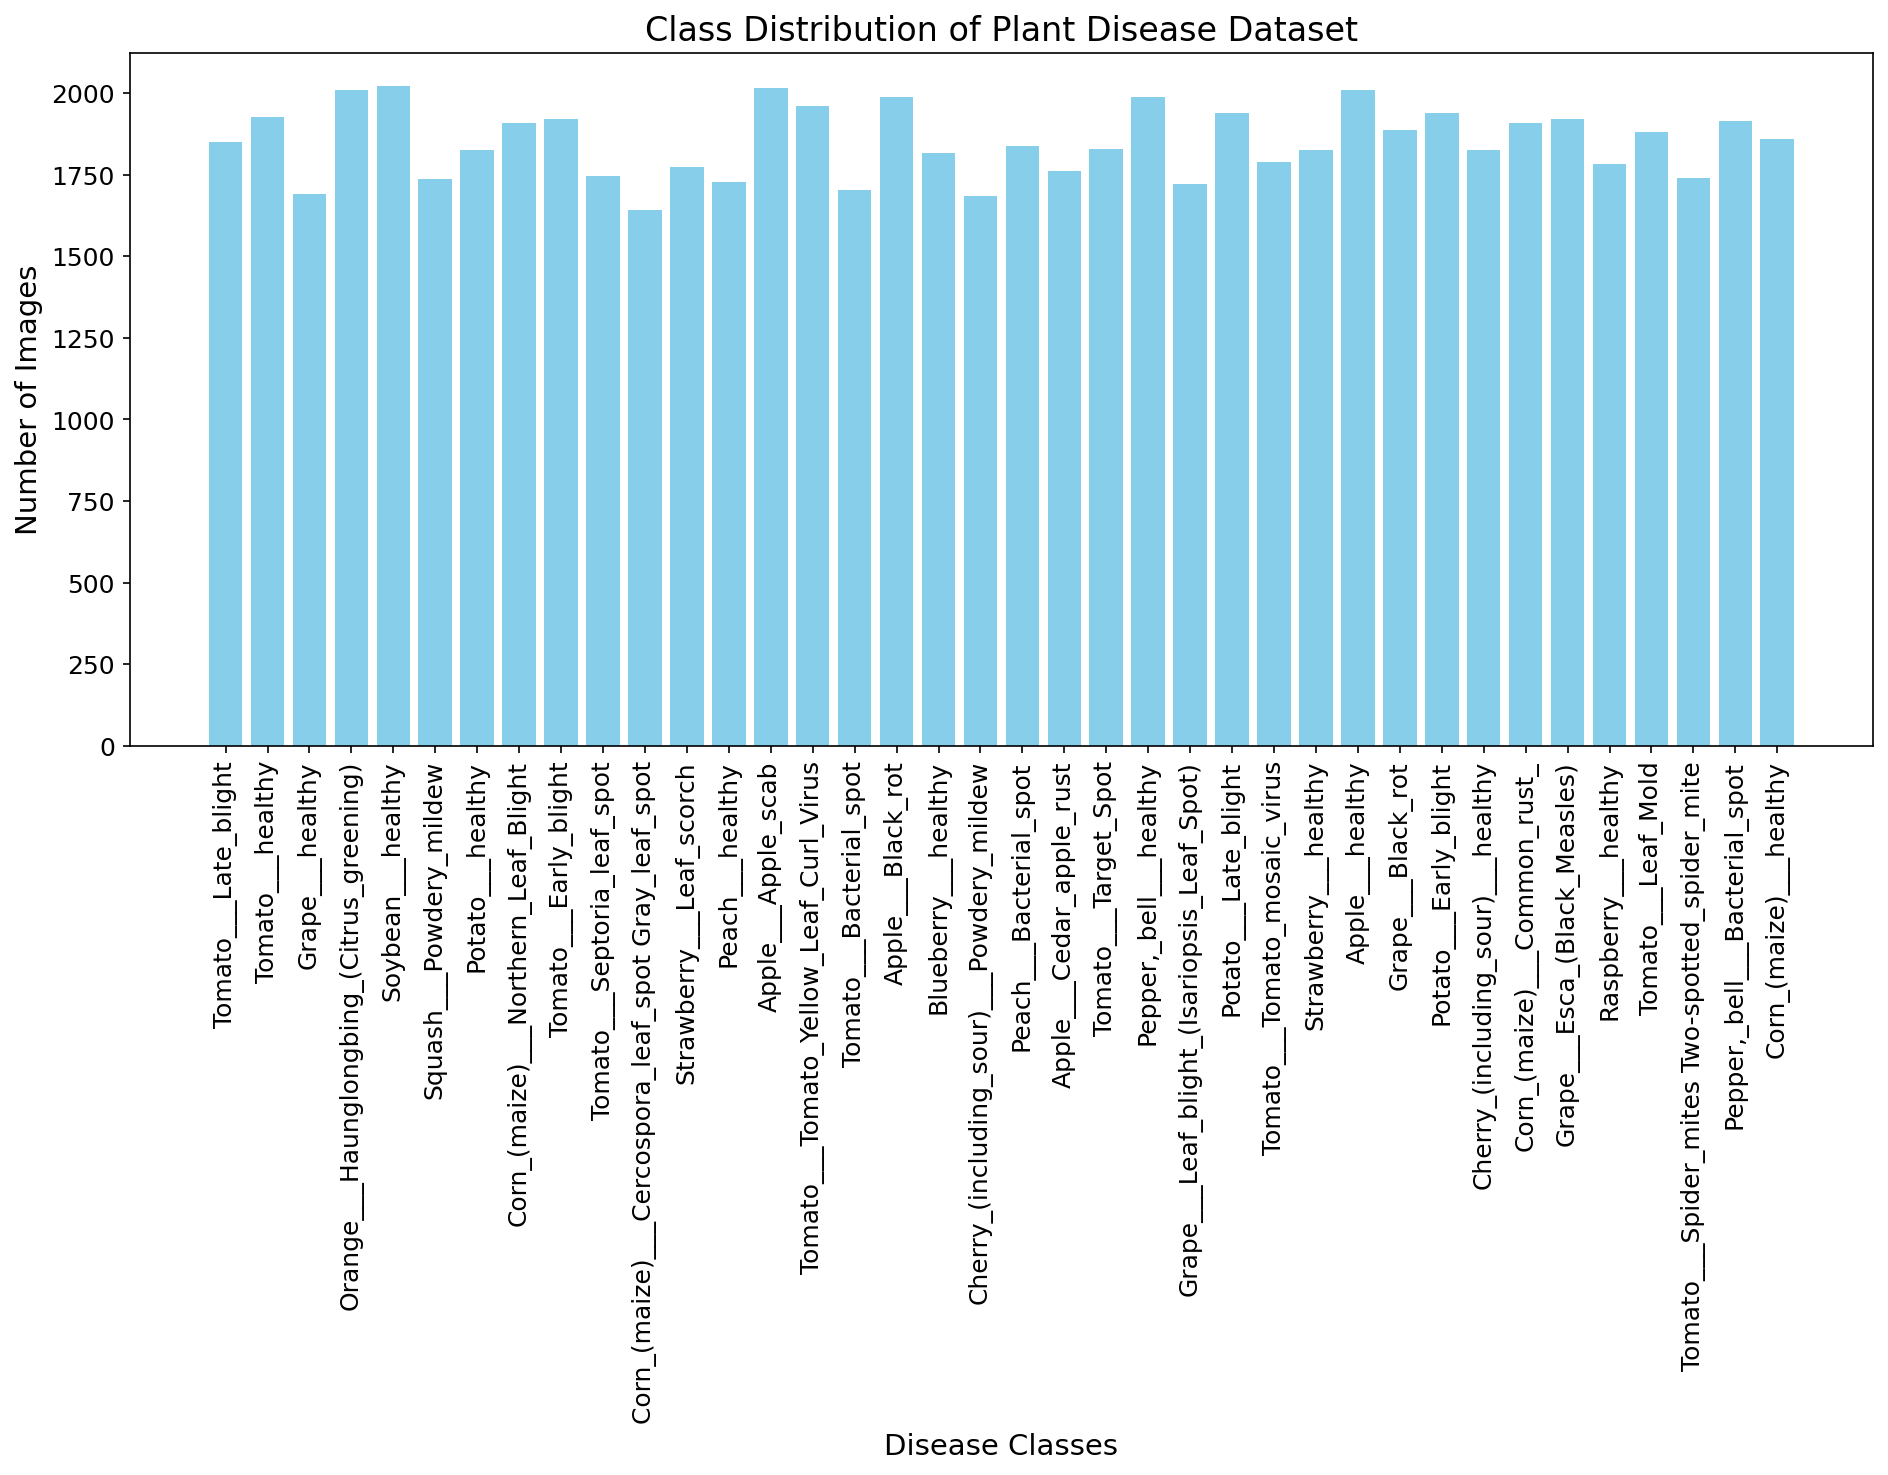

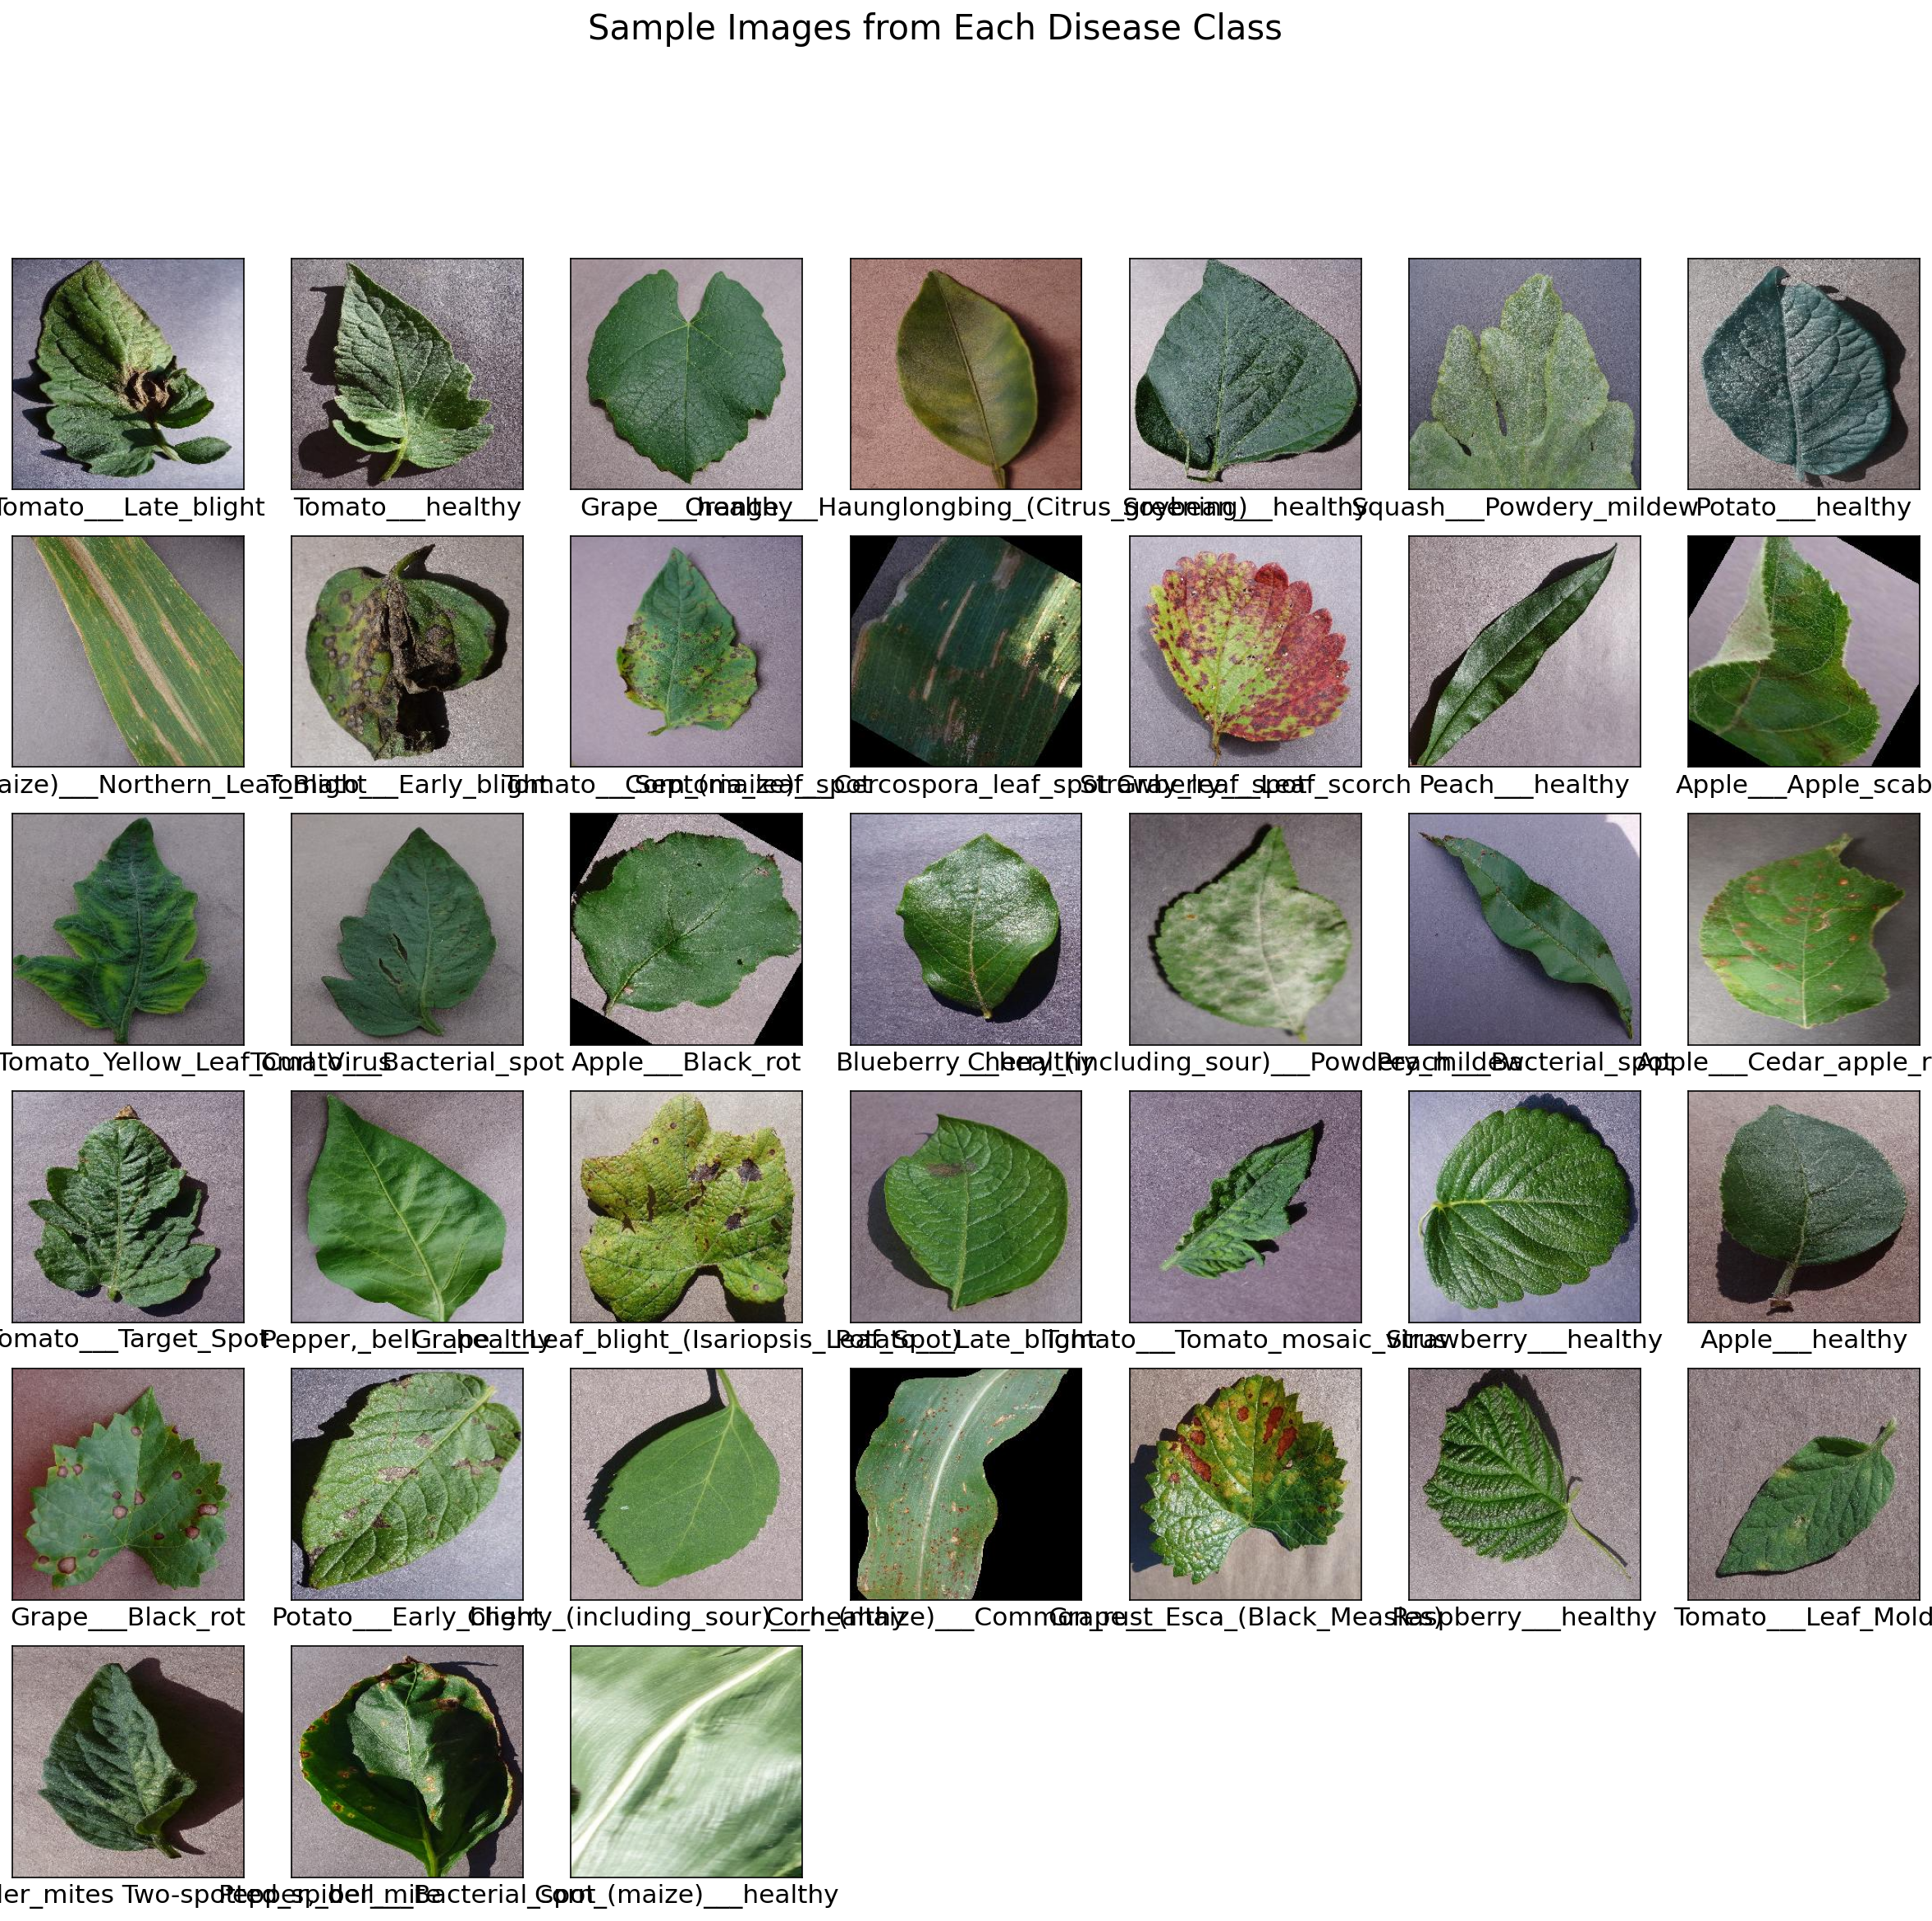

In [5]:
import matplotlib.pyplot as plt
import os

# Variables to store image counts
image_counts = {}
sample_images = []

# Iterate through each disease class and count the number of images
for disease in Diseases_classes:
    image_files = os.listdir(os.path.join(train_dir, disease))
    image_counts[disease] = len(image_files)
    
    # Store a sample image path for visualization
    if image_files:
        sample_images.append((disease, os.path.join(train_dir, disease, image_files[0])))

# Plot histogram for class distribution
plt.figure(figsize=(15, 6), dpi=150)
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')

# Format the plot
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Disease Classes", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Class Distribution of Plant Disease Dataset", fontsize=16)

# Show the histogram
plt.show()

# Display sample images from each class
plt.figure(figsize=(20, 20), dpi=150)

for idx, (disease, img_path) in enumerate(sample_images, start=1):
    plt.subplot(7, 7, idx)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.xlabel(disease, fontsize=15)
    plt.xticks([])
    plt.yticks([])

plt.suptitle("Sample Images from Each Disease Class", fontsize=20)
plt.show()

## **Exploring Class Imbalance And Other Statistics**

#### This cell analyzes the class distribution in the plant disease dataset by computing key statistics such as the class imbalance ratio, mean, median, and standard deviation of image counts across different disease categories. The imbalance ratio of 1.23 suggests a mild imbalance, meaning some disease classes have slightly more images than others. A box plot is also used to visualize the spread of image counts, helping assess dataset balance before model training.


Class Imbalance Ratio: 1.23
Mean Number of Images per Class: 1849.87
Median Number of Images per Class: 1844.50
Standard Deviation of Image Counts: 104.32


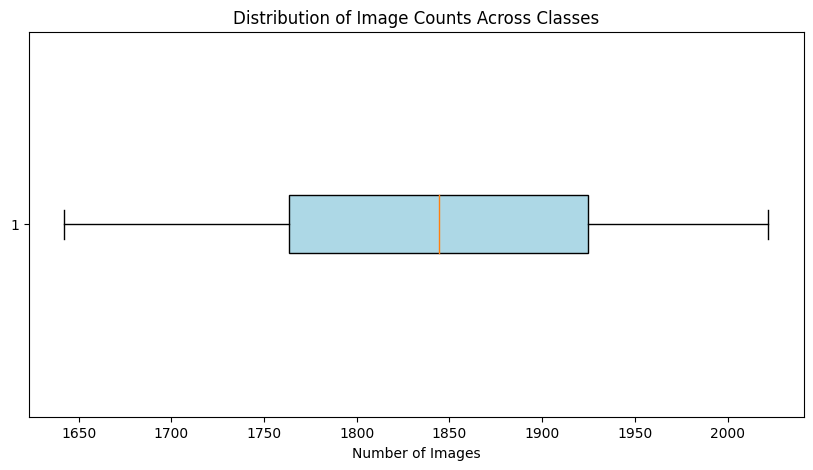

In [6]:
# Extract image counts
image_counts_list = list(image_counts.values())

# Calculate imbalance ratio (ratio of max class count to min class count)
max_images = max(image_counts_list)
min_images = min(image_counts_list)
imbalance_ratio = max_images / min_images

# Calculate key statistics
mean_images = np.mean(image_counts_list)
median_images = np.median(image_counts_list)
std_dev_images = np.std(image_counts_list)

# Print statistics
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")
print(f"Mean Number of Images per Class: {mean_images:.2f}")
print(f"Median Number of Images per Class: {median_images:.2f}")
print(f"Standard Deviation of Image Counts: {std_dev_images:.2f}")

# Visualizing class distribution with a box plot
plt.figure(figsize=(10, 5))
plt.boxplot(image_counts_list, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Number of Images")
plt.title("Distribution of Image Counts Across Classes")
plt.show()

## **Loading the training and validation Data**


#### This cell defines key parameters for training a deep learning model, including batch size, number of epochs, and image dimensions. It then loads the training and validation datasets from their respective directories using TensorFlow's image_dataset_from_directory function, preparing the images for efficient processing in batches. The datasets are structured for model input with automatic optimization (AUTOTUNE) to improve pipeline performance.


In [7]:
BATCH_SIZE = 32
EPOCHS = 25 
IMAGE_SIZE = 224
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


# Loading datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        seed=123,
        shuffle=True,
        image_size=default_image_size,
        batch_size=BATCH_SIZE
    )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        valid_dir,
        seed=123,
        shuffle=True,
        image_size=default_image_size,
        batch_size=BATCH_SIZE
    )

Found 70295 files belonging to 38 classes.


I0000 00:00:1747369736.756921      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 17572 files belonging to 38 classes.


## **Defining processing function for test images**

#### This function prepares images for inference with the ResNet101 model by performing essential preprocessing steps. It takes an image file path as input and returns a properly formatted NumPy array ready for model prediction.

In [8]:
# Function to process image data (for images from file)
def process_image(img_path) -> np.ndarray:
    # Open image using PIL from file path
    image = Image.open(img_path)
    
    # Convert PIL Image to numpy array
    image_array = np.array(image)
    image_array = cv2.resize(image_array, (224, 224))
    
    # Add batch dimension
    img_batch = np.expand_dims(image_array, axis=0)
    
    return img_batch

## **Defining predict function for inference**

#### This function handles the inference process by taking a preprocessed image and a trained model as inputs, then returning structured prediction results. It serves as the final step in the classification pipeline, converting raw model outputs into human-interpretable results.

In [9]:
def predict(model, img):
    predictions = model.predict(img)

    predicted_index = np.argmax(predictions[0])
    predicted_class = cleaned_class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_index, predicted_class, confidence

## **Definning cleaned class names to be used for calculating metrics**

In [10]:
cleaned_class_names = ['AppleScab', 'AppleBlackRot', 'AppleCedarRust', 'AppleHealthy', 'BlueberryHealthy', 'Cherry(includingSour)PowderyMildew', 'Cherry(includingSour)Healthy', 'Corn(maize)CercosporaLeafSpot grayLeafSpot', 'CornCommonRust', 'Corn(maize)NorthernLeafBlight', 'Corn(maize)Healthy', 'GrapeBlackRot', 'GrapeEsca(blackMeasles)', 'GrapeLeafBlight(isariopsisLeafSpot)', 'GrapeHealthy', 'OrangeHaunglongbing(citrusGreening)', 'PeachBacterialSpot', 'PeachHealthy', 'Pepper,BellBacterialSpot', 'Pepper,BellHealthy', 'PotatoEarlyBlight', 'PotatoLateBlight', 'PotatoHealthy', 'RaspberryHealthy', 'SoybeanHealthy', 'SquashPowderyMildew', 'StrawberryLeafScorch', 'StrawberryHealthy', 'TomatoBacterialSpot', 'TomatoEarlyBlight', 'TomatoLateBlight', 'TomatoLeafMold', 'TomatoSeptoriaLeafSpot', 'TomatoSpiderMites two-spottedSpiderMite', 'TomatoTargetSpot', 'TomatoYellowCurlVirus', 'TomatoMosaicVirus', 'TomatoHealthy']

## **Helper function for formatting labels**

In [11]:
def remove_digits_from_list(str_list):
    return [''.join([char for char in s if not char.isdigit()]) for s in str_list]

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained DenseNet121 (weights from ImageNet)
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,               # Remove the original classification head
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom classification head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)        # Ensure frozen base
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)                            # Dropout to reduce overfitting
outputs = Dense(38, activation='softmax')(x)   # 38 output classes

# Build and compile the model
DenseNet121_featureExtract = Model(inputs, outputs)

DenseNet121_featureExtract.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

DenseNet121_featureExtract.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38)                  │          38,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,076,454 (26.99 MB)

 Trainable params: 38,950 (152.15 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [14]:
# Train only the new head
history_resnet101 = DenseNet121_featureExtract.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds
)

Epoch 1/25


I0000 00:00:1747250567.087993     105 service.cc:148] XLA service 0x7e32200033e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747250567.088917     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747250569.904220     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/2197 ━━━━━━━━━━━━━━━━━━━━ 1:45 48ms/step - accuracy: 0.0208 - loss: 11.3361       

I0000 00:00:1747250580.502067     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 197s 75ms/step - accuracy: 0.0858 - loss: 7.6502 - val_accuracy: 0.6006 - val_loss: 1.5228
Epoch 2/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 120s 55ms/step - accuracy: 0.3464 - loss: 2.7873 - val_accuracy: 0.7130 - val_loss: 1.0927
Epoch 3/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 119s 54ms/step - accuracy: 0.5066 - loss: 1.8175 - val_accuracy: 0.7611 - val_loss: 0.9129
Epoch 4/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 122s 55ms/step - accuracy: 0.5912 - loss: 1.4286 - val_accuracy: 0.7906 - val_loss: 0.8166
Epoch 5/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 123s 56ms/step - accuracy: 0.6364 - loss: 1.2624 - val_accuracy: 0.8062 - val_loss: 0.7581
Epoch 6/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.6633 - loss: 1.1669 - val_accuracy: 0.8141 - val_loss: 0.7242
Epoch 7/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.6788 - loss: 1.1089 - val_accuracy: 0.8231 - val_loss: 0.6891
Epoch 8/25
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.6915 - lo

In [15]:
history_densenet=history_resnet101

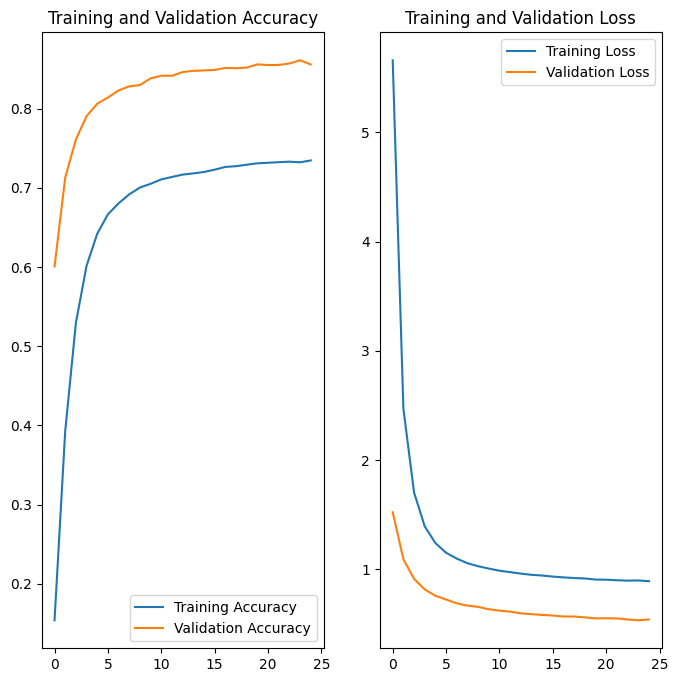

In [16]:
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']

loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [17]:
DenseNet121_featureExtract.save(f"/kaggle/working/DenseNet121_featureExtract.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

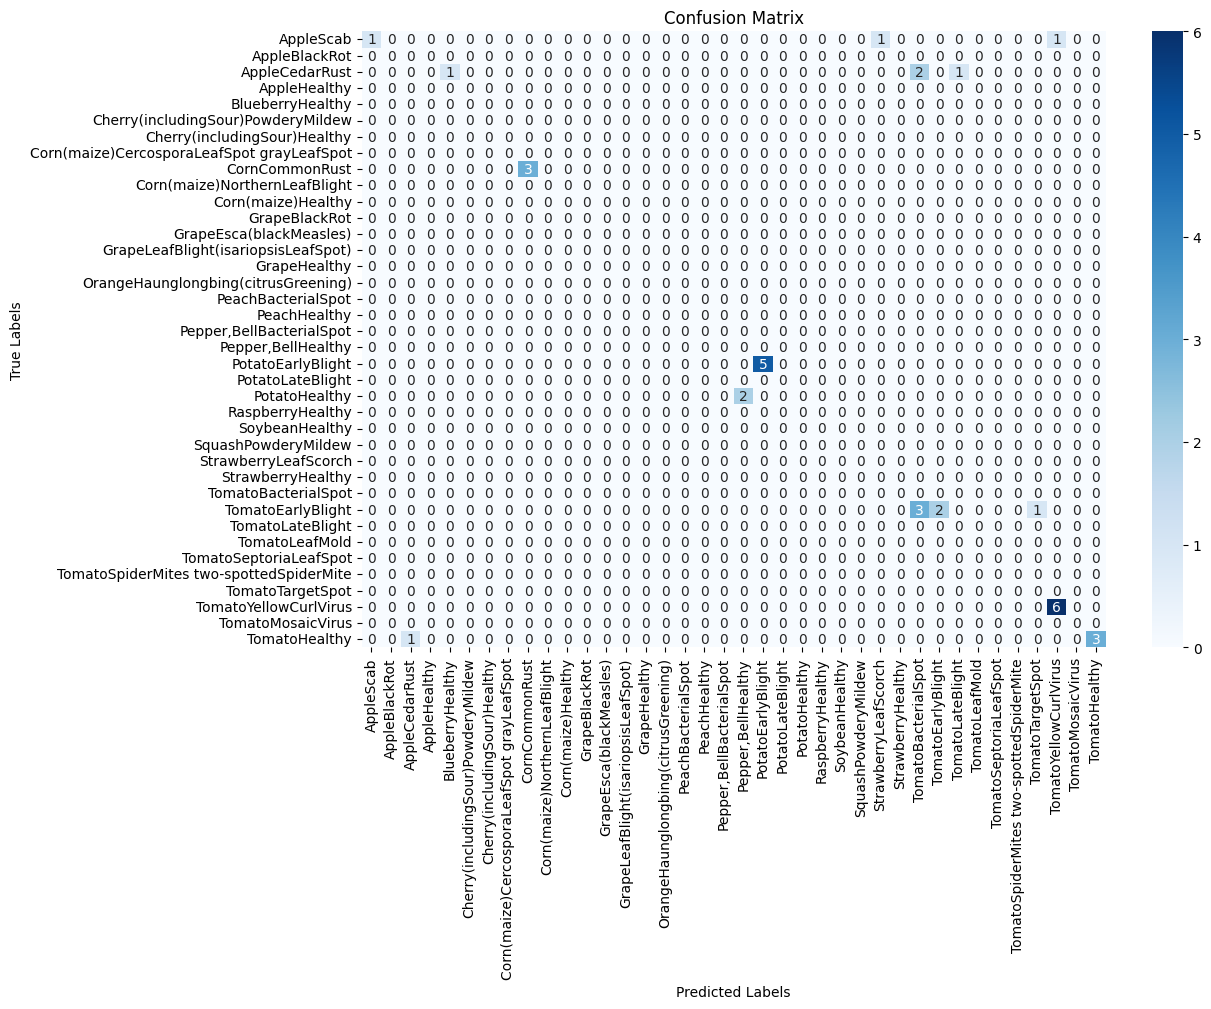


Classification Report:

                       precision    recall  f1-score   support

       AppleCedarRust       0.00      0.00      0.00         4
            AppleScab       1.00      0.33      0.50         3
     BlueberryHealthy       0.00      0.00      0.00         0
       CornCommonRust       1.00      1.00      1.00         3
   Pepper,BellHealthy       0.00      0.00      0.00         0
    PotatoEarlyBlight       1.00      1.00      1.00         5
        PotatoHealthy       0.00      0.00      0.00         2
 StrawberryLeafScorch       0.00      0.00      0.00         0
  TomatoBacterialSpot       0.00      0.00      0.00         0
    TomatoEarlyBlight       1.00      0.33      0.50         6
        TomatoHealthy       1.00      0.75      0.86         4
     TomatoLateBlight       0.00      0.00      0.00         0
     TomatoTargetSpot       0.00      0.00      0.00         0
TomatoYellowCurlVirus       0.86      1.00      0.92         6

             accuracy       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [25]:
# Store predictions and actual labels
true_labels = []
predicted_labels = []
misclassified_samples = []
test_images = os.listdir(test_dir)
# Predict for each test image
for img_path in test_images:
    actual_class = img_path.split('.')[0].replace('_', ' ')  # Extract actual label
    img = process_image(os.path.join(test_dir, img_path))  # Process image for model input
    predicted_index, predicted_class, confidence = predict(DenseNet121_featureExtract, img)  # Get predictions
    
    true_labels.append(actual_class)
    predicted_labels.append(predicted_class)
    actual_class = [actual_class]
    actual_class = remove_digits_from_list(actual_class)

    # Track misclassified samples
    if actual_class[0] != predicted_class:
        misclassified_samples.append((actual_class, predicted_class, img_path))

# Generate confusion matrix
cleaned_true_labels = remove_digits_from_list(true_labels)
conf_matrix = confusion_matrix(cleaned_true_labels, predicted_labels, labels=cleaned_class_names)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cleaned_class_names, yticklabels=cleaned_class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n")
detected_classes = list(set(cleaned_true_labels))
print(classification_report(cleaned_true_labels, predicted_labels))

# Display misclassified samples
plt.figure(figsize=(15, 15))

## **Conclusion:**
## Since densenet did not give the results as they should have been, we decided not to experiment with this further.